# Ames Housing Data Preprocessing and Feature Engineering

This project aims to predict housing prices in Ames, Iowa based on the famous Ames Iowa Housing Dataset from the Ames City Assessor's Office, made available by Dean De Cock of Truman University in 2011. Professor De Cock's original paper can be found [here.](http://jse.amstat.org/v19n3/decock.pdf)

Presentation Slides for this project can be found [here.](https://www.beautiful.ai/player/-N4J5UYshyuRtwl5G4I7)

This notebook includes python code for data extraction, cleaning and transformation. Model Fitting and Analysis code can be found in the Ames_Models notebook.

# Sections and steps

- <a href="#IMP">Reading in Data</a><br>
- <a href="#FEN">Feature Engineering</a><br>
    - <a href="#SP">Second Pass - Analysis</a><br>
    - <a href="#SP"> Summary of Feature Engineering </a><br>
- <a href="#PRE">Preparing Data for Models</a><br>
    - Linear Models
        -dummify categorical variables
    - Non Linear Models
        -label encode categorical variables
    - All Models
        -split train and validate datasets
        -standardize the numerical variables
- <a href="#EXP">Exporting Cleaned Datasets</a><br>

<p><a name="IMP"></a></p>

## Importing Packages, Reading in Data

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#helper module
from helper_module import *

#setting options to view dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#warnings
import warnings
warnings.filterwarnings("ignore")

#helper module functionality
%load_ext autoreload
%autoreload 2

#### Reading in train data

In [2]:
train = pd.read_csv('./data/cleaned/train_c.csv')
train.head()
#train.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Train Data - Shape: {train.shape}")

Read in Ames Housing Train Data - Shape: (1430, 55)


In [3]:
train.drop('Unnamed: 0', axis=1, inplace = True)
train.head()

,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,GrLivArea,BedroomAbvGr,WoodDeckSF,OpenPorchSF,log_SalePrice,AgeHome,YrsSnRmdl,TotBthrm,HasFireplace,HasFence,HasGarage,NearNeg,SalePrice,MSZoning,LotShape,LandContour,LotConfig,BldgType,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,NeighbQual
0,65,8450,7,196,706,150,856,854,1710,3,0,61,12.247694,5,5,3.5,0,0,1,0,208500,RL,Reg,Lvl,Inside,1Fam,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NoFireplace,Attchd,RFn,2,TA,TA,Y,WD,Normal,TA
1,80,9600,6,0,978,284,1262,0,1262,3,298,0,12.109011,31,31,2.5,1,0,1,1,181500,RL,Reg,Lvl,FR2,1Fam,Gable,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,2,TA,TA,Y,WD,Normal,Ex
2,68,11250,7,162,486,434,920,866,1786,3,0,42,12.317167,7,6,3.5,1,0,1,0,223500,RL,IR1,Lvl,Inside,1Fam,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,2,TA,TA,Y,WD,Normal,TA
3,60,9550,7,0,216,540,756,756,1717,3,0,35,11.849398,91,36,2.0,1,0,1,0,140000,RL,IR1,Lvl,Corner,1Fam,Gable,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,3,TA,TA,Y,WD,Abnorml,Ex
4,84,14260,8,350,655,490,1145,1053,2198,4,192,84,12.429216,8,8,3.5,1,0,1,0,250000,RL,IR1,Lvl,FR2,1Fam,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,3,TA,TA,Y,WD,Normal,Ex


In [4]:
train.dtypes

LotFrontage        int64
LotArea            int64
OverallQual        int64
MasVnrArea         int64
BsmtFinSF1         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
2ndFlrSF           int64
GrLivArea          int64
BedroomAbvGr       int64
WoodDeckSF         int64
OpenPorchSF        int64
log_SalePrice    float64
AgeHome            int64
YrsSnRmdl          int64
TotBthrm         float64
HasFireplace       int64
HasFence           int64
HasGarage          int64
NearNeg            int64
SalePrice          int64
MSZoning          object
LotShape          object
LandContour       object
LotConfig         object
BldgType          object
RoofStyle         object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinType2      object
Heating           object
HeatingQC         object


In [5]:
#making sure the binary variables are categorical
for var in ['HasFireplace', 'HasFence', 'HasGarage', 'NearNeg']:
    train[var]= train[var].astype(str)

<p><a name="PRE"></a></p>

## Preprocessing Data for Models

In [6]:
cat_var = train.select_dtypes('O').columns.tolist()
num_var = train.select_dtypes('number').columns.tolist()
print(len(num_var),' numerical variables')
print(len(cat_var),' categorical variables')

18  numerical variables
36  categorical variables


In [88]:
SalePrice = train['SalePrice']
log_Price = train['log_SalePrice']

In [89]:
train.drop('SalePrice', axis = 1, inplace = True)
train.drop('log_SalePrice', axis = 1, inplace = True)

### Linear Models
#### Dummification of Categorical Variables

In [90]:
preproc = pd.get_dummies(train, columns = cat_var, drop_first=True)

In [91]:
print(train.shape)
print(preproc.shape)

(1430, 52)
(1430, 168)


In [92]:
preproc.head()

,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,GrLivArea,BedroomAbvGr,WoodDeckSF,OpenPorchSF,AgeHome,YrsSnRmdl,TotBthrm,GarageCars,HasFireplace_1,HasFence_1,HasGarage_1,NearNeg_1,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NoBasement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBasement,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_other,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_other,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,NeighbQual_Fa,NeighbQual_Gd,NeighbQual_Po,NeighbQual_TA
0,65,8450,7,196,706,150,856,854,1710,3,0,61,5,5,3.5,2,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,80,9600,6,0,978,284,1262,0,1262,3,298,0,31,31,2.5,2,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,68,11250,7,162,486,434,920,866,1786,3,0,42,7,6,3.5,2,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,60,9550,7,0,216,540,756,756,1717,3,0,35,91,36,2.0,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
preproc, log_Price, test_size = 0.3, random_state = 22)

In [94]:
X_train.head()

,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,GrLivArea,BedroomAbvGr,WoodDeckSF,OpenPorchSF,AgeHome,YrsSnRmdl,TotBthrm,GarageCars,HasFireplace_1,HasFence_1,HasGarage_1,NearNeg_1,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NoBasement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBasement,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_other,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_other,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,NeighbQual_Fa,NeighbQual_Gd,NeighbQual_Po,NeighbQual_TA
1357,80,16692,7,184,790,133,1392,1392,2784,5,0,112,28,28,4.5,2,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1311,120,9560,5,0,360,504,864,0,864,3,0,0,34,34,1.0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1290,50,14781,8,178,0,1753,1753,0,1787,3,198,150,5,4,2.0,3,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
307,65,7800,5,0,507,286,793,325,1118,3,0,0,67,56,2.0,2,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,

##### Standardizing numerical variables

In [95]:
nlist = list(train.select_dtypes('number'))
print('Numerical Column Names: \n', nlist)

num_indx = []
for nvar in nlist:
    num_indx.append(train.select_dtypes('number').columns.get_loc(nvar))
    
print('\nNumerical Columns Indices: \n', num_indx)

Numerical Column Names: 
 ['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'AgeHome', 'YrsSnRmdl', 'TotBthrm', 'GarageCars']

Numerical Columns Indices: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [96]:
num_indx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

t = [('num', StandardScaler(), num_indx)]
transf = ColumnTransformer(transformers = t,
                          remainder = 'passthrough')

In [98]:
num_indx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [99]:
X_train_scaled = transf.fit_transform(X_train)
X_test_scaled = transf.transform(X_test)

In [100]:
X_train_scaled.shape

(1001, 168)

In [101]:
def look_num(varlist):
    count = 0
    for var in varlist:
        print(var)
        x = X_train_scaled[:,count]
        y = y_train
        print('*'*50)
            
        #info about pearson's correlation
        corr = pearsonr(x, y)
        print('Pearsons correlation (r):', round(corr[0],3))
        count += 1
        print('*'*50)
        
        #Figures
        sns.set_theme(style="whitegrid")
        
        #seaborn Histogram
        f, ax = plt.subplots(1, 2, figsize = (10,6))
        sns.histplot(x=x, data=X_train_scaled, ax = ax[0])
        plt.xticks(rotation = 45)
        
        #seaborn Scatterplot
        sns.scatterplot(x=x, y = y, ax = ax[1])
        plt.xticks(rotation=45)
        
        yield f.show()

In [102]:
view_num = look_num(nlist)

LotFrontage
**************************************************
Pearsons correlation (r): 0.326
**************************************************


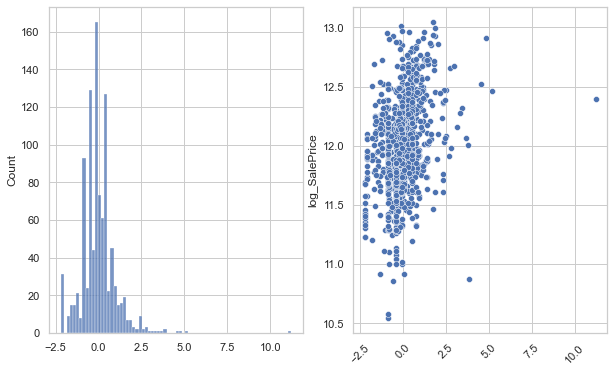

In [103]:
next(view_num)

# TESTING


In [104]:
def get_residuals(model, X, Y):
    
    residuals = Y - model.predict(X)
    
    return residuals

In [105]:
def model_evaluate(model, X, Y):
    import numpy as np
    from sklearn.metrics import mean_squared_error, r2_score

    rmse = mean_squared_error(Y, 
                            model.predict(X), 
                            squared = False)
    r2 = r2_score(Y, model.predict(X))
    
    if len(np.where(model.predict(X)>20)[0]) > 0: # specific to this dataset
        # Issue, model prediction is too large
        rmse_dollars = np.nan
    else:
        rmse_dollars = mean_squared_error(np.exp(Y), 
                            np.exp(model.predict(X)), 
                            squared = False)

    print('RMSE Logarithmic: ', rmse)
    print('r^2: ', r2)
    print('RMSE: $', rmse_dollars)
    
    return rmse, r2, rmse_dollars

In [106]:
def plot_the_model(model, x_train, y_train, x_test, y_test):
    import numpy as np
    from matplotlib import pyplot as plt

    fig, axs = plt.subplots(1,2) 
    fig.set_figheight(5)
    fig.set_figwidth(10)

    x = np.linspace(10, 14.5, 100)
    y = np.linspace(10, 14.5, 100)
    
    # --------------------------------
    # Plot the Actual vs. Predicted
    # --------------------------------
    axs[0].scatter(model.predict(x_train), 
         y_train, color='k')
    axs[0].plot(x,y, 'r-')
 
    axs[0].set_ylabel('Actual log of Sale Price')
    axs[0].set_xlabel('Predicted log of Sale Price')
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].legend(['line','Train'])
    
    axs[1].scatter(model.predict(x_test), 
         y_test, color='magenta') 
    axs[1].plot(x,y, 'r-')

    axs[1].set_ylabel('Actual log of Sale Price')
    axs[1].set_xlabel('Predicted log of Sale Price')
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].legend(['line','Test'])

In [107]:
def get_linear_regress_model(X, Y):
    from sklearn.linear_model import LinearRegression
    lm = LinearRegression()
    
    model = lm.fit(X, Y)
    print('LM model object created.')
    
    return model

In [108]:
def get_lasso_model(X, Y):
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold

    skfold = KFold(n_splits=5, shuffle=True, random_state=0)
    lasso_gs  = Lasso()
    lasso_gs.set_params(normalize=False)

    params = {
        "alpha": [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
    }

    gs = GridSearchCV(lasso_gs, params, scoring = 'r2', cv=skfold)
    gs.fit(X, Y)
    
    model = gs.best_estimator_
    
    print('Lasso model object created.')
    print(gs.best_estimator_)
    
    return model

In [109]:
def get_ridge_model(X, Y):
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold

    skfold = KFold(n_splits=3, shuffle=True, random_state=0)
    ridge_gs  = Ridge()
    ridge_gs.set_params(normalize=False)

    params = {
        "alpha": [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
    }

    gs = GridSearchCV(ridge_gs, params, scoring = 'r2', cv=skfold)
    gs.fit(X, Y)
    
    model = gs.best_estimator_
    
    print('Ridge model object created.')
    print(gs.best_estimator_)
    
    return model

In [110]:
def get_elasticNet_model(X, Y):
    from sklearn.linear_model import ElasticNet
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold

    skfold = KFold(n_splits=3, shuffle=True, random_state=0)
    elastic_gs  = ElasticNet()
    elastic_gs.set_params(normalize=False)

    params = [{
        "alpha": [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01],
        "l1_ratio":[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
    }]

    gs = GridSearchCV(elastic_gs, params, scoring = 'r2', cv=skfold)
    gs.fit(X_train_scaled, y_train)
    
    model = gs.best_estimator_
    
    print('Elastic Net model object created.')
    print(gs.best_estimator_)
    
    return model

In [111]:
# initializing these variables for model comparision
model_descrp = []
r2_log_train = []
r2_log_test = []
rmse_log_train = []
rmse_log_test = []
rmse_dollars_train = []
rmse_dollars_test = []

In [112]:
def append_myMetrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars):
    
    r2_log_train_temp = r2_train
    r2_log_test_temp = r2_test
    rmse_log_train_temp = rmse_train
    rmse_log_test_temp = rmse_test
    rmse_dollars_train_temp = rmse_train_dollars
    rmse_dollars_test_temp = rmse_test_dollars

    model_descrp.append(which_model)
    if r2_log_train_temp <= 1 and r2_log_train_temp > 0:
        r2_log_train.append(r2_log_train_temp)
    elif r2_log_train_temp > 1:   
        r2_log_train.append(1000)
    else:
        r2_log_train.append(-1000)

    if r2_log_test_temp <= 1 and r2_log_test_temp > 0:
        r2_log_test.append(r2_log_test_temp)
    elif r2_log_test_temp > 1:   
        r2_log_test.append(1000)
    else:
        r2_log_test.append(-1000)
    
    if rmse_log_train_temp <= 10:
        rmse_log_train.append(rmse_log_train_temp)
    elif rmse_log_train_temp > 10:   
        rmse_log_train.append(1000)

    if rmse_log_test_temp <= 10:
        rmse_log_test.append(rmse_log_test_temp)
    elif rmse_log_test_temp > 10:   
        rmse_log_test.append(1000)
    
    rmse_dollars_train.append(rmse_dollars_train_temp)
    rmse_dollars_test.append(rmse_dollars_test_temp)

In [113]:
#linear regression model
lm_model = get_linear_regress_model(X_train_scaled, y_train)

LM model object created.


In [114]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(lm_model, X_train_scaled, y_train)

RMSE Logarithmic:  0.09649116655193472
r^2:  0.9361680332637698
RMSE: $ 16707.298203867165


In [117]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(lm_model, X_test_scaled, y_test)

RMSE Logarithmic:  7892282464.363702
r^2:  -4.5378021224463335e+20
RMSE: $ nan


Text(0.5, 0, 'Residual')

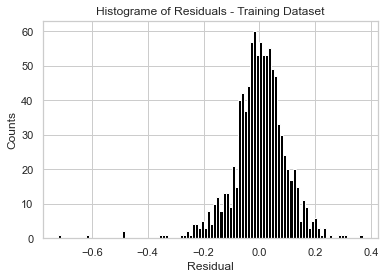

In [118]:
residuals_train = get_residuals(lm_model, X_train_scaled, y_train)
plt.hist(residuals_train, 100, facecolor = 'black');
plt.title('Histograme of Residuals - Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Text(0.5, 0, 'Residual')

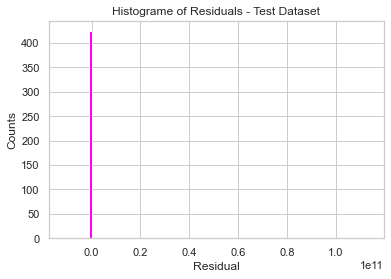

In [119]:
residuals_test = get_residuals(lm_model, X_test_scaled, y_test)
plt.hist(residuals_test, 100, facecolor = 'magenta');
plt.title('Histograme of Residuals - Test Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Linear Regression Model - No Regularization


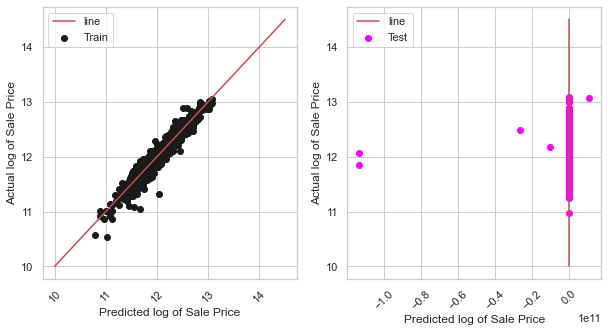

In [120]:
print('Linear Regression Model - No Regularization');
plot_the_model(lm_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [121]:
which_model = 'Linear Regression'
append_myMetrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

In [122]:
#Lasso

In [123]:
from sklearn.linear_model import Lasso
lasso  = Lasso()
lasso.set_params(normalize=False)
lasso_scores_train = []
lasso_scores_test  = []

alphas = np.linspace(0.0001,0.05,100)
coefs_lasso  = []

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X_train_scaled, y_train)  
        coefs_lasso.append(lasso.coef_)
        
        lasso_scores_train.append(lasso.score(X_train_scaled, y_train))
        lasso_scores_test.append(lasso.score(X_test_scaled, y_test))

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = preproc.columns)  
# coefs_lasso.head()

In [124]:
lasso_scores_train = np.array(lasso_scores_train) 
lasso_scores_test  = np.array(lasso_scores_test)

lambda =  0.004636363636363637


Text(0, 0.5, '$R^2$')

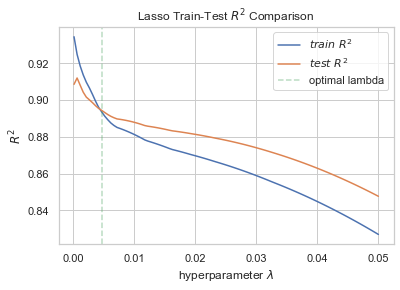

In [125]:
plt.plot(alphas, lasso_scores_train, label=r'$train\ R^2$')
plt.plot(alphas, lasso_scores_test, label=r'$test\ R^2$')
plt.title(r'Lasso Train-Test $R^2$ Comparison')

lasso_underfit = lasso_scores_train < lasso_scores_test
first_underfit  = np.min(alphas[lasso_underfit])
print('lambda = ', first_underfit)
plt.axvline(first_underfit, linestyle='--', color='g', label='optimal lambda', alpha=0.4)

plt.legend(loc=1)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

In [126]:
#Lasso 2.0

In [127]:
lasso_model = get_lasso_model(X_train_scaled, y_train)

Lasso model object created.
Lasso(alpha=0.001)


In [128]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(lasso_model, X_train_scaled, y_train)

RMSE Logarithmic:  0.10830712552289841
r^2:  0.9195775736883673
RMSE: $ 18592.686848213918


In [129]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(lasso_model, X_test_scaled, y_test)

RMSE Logarithmic:  0.1118213814889488
r^2:  0.9089059480636232
RMSE: $ 20801.95745835562


Text(0.5, 0, 'Residual')

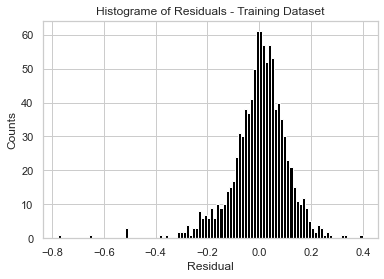

In [130]:
residuals_train = get_residuals(lasso_model, X_train_scaled, y_train)
plt.hist(residuals_train, 100, facecolor = 'black');
plt.title('Histograme of Residuals - Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Text(0.5, 0, 'Residual')

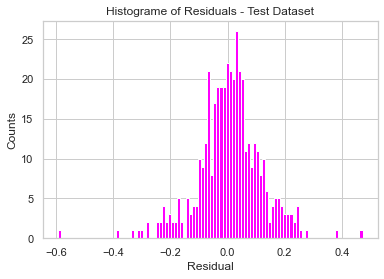

In [131]:
residuals_test = get_residuals(lasso_model, X_test_scaled, y_test)
plt.hist(residuals_test, 100, facecolor = 'magenta');
plt.title('Histograme of Residuals - Test Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Linear Regression Model - Lasso


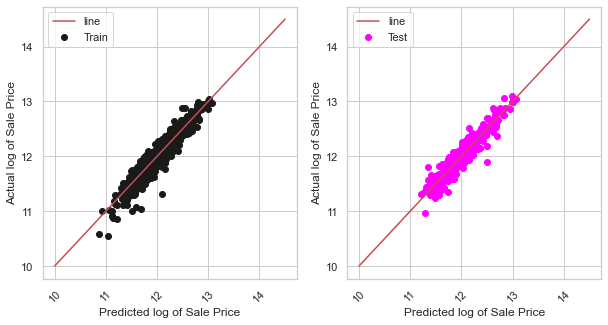

In [132]:
print('Linear Regression Model - Lasso');
plot_the_model(lasso_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [134]:
which_model = 'Lasso'
append_myMetrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

In [135]:
#Ridge

In [136]:
ridge_model = get_ridge_model(X_train_scaled, y_train)

Ridge model object created.
Ridge(alpha=0.01)


In [137]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(ridge_model, X_train_scaled, y_train)

RMSE Logarithmic:  0.09629376480088715
r^2:  0.9364289411448523
RMSE: $ 16707.59995433144


In [138]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(ridge_model, X_test_scaled, y_test)

RMSE Logarithmic:  0.11805544866717313
r^2:  0.8984657919875748
RMSE: $ 20995.40829806824


Text(0.5, 0, 'Residual')

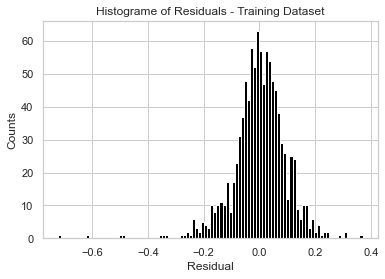

In [139]:
residuals_train = get_residuals(ridge_model, X_train_scaled, y_train)
plt.hist(residuals_train, 100, facecolor = 'black');
plt.title('Histograme of Residuals - Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Text(0.5, 0, 'Residual')

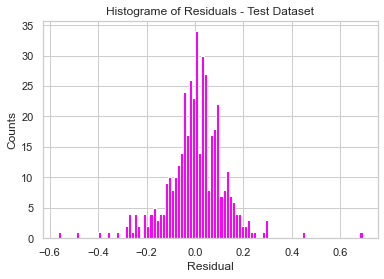

In [140]:
residuals_test = get_residuals(ridge_model, X_test_scaled, y_test)
plt.hist(residuals_test, 100, facecolor = 'magenta');
plt.title('Histograme of Residuals - Test Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Linear Regression Model - Ridge


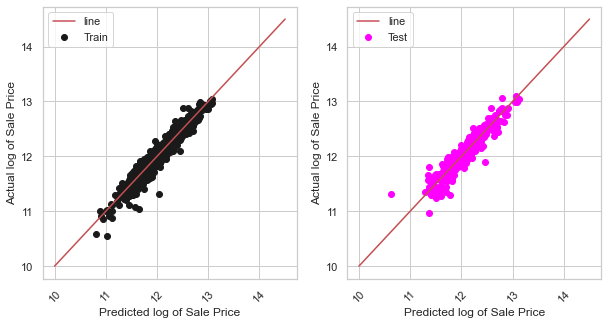

In [141]:
print('Linear Regression Model - Ridge');
plot_the_model(ridge_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [142]:
which_model = 'Ridge'
append_myMetrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

In [ ]:
#Elastic Net

In [143]:
EN_model = get_elasticNet_model(X_train_scaled, y_train)

Elastic Net model object created.
ElasticNet(alpha=0.004, l1_ratio=0.1)


In [144]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(EN_model, X_train_scaled, y_train)

RMSE Logarithmic:  0.10385942986014218
r^2:  0.9260471389771744
RMSE: $ 17870.991811683056


In [145]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(EN_model, X_test_scaled, y_test)

RMSE Logarithmic:  0.10913394655222286
r^2:  0.913231910565631
RMSE: $ 20412.398775795475


Text(0.5, 0, 'Residual')

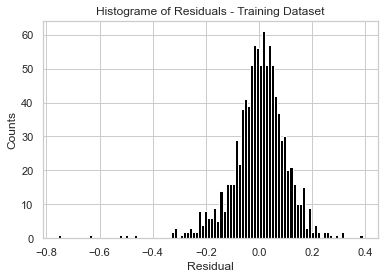

In [146]:
residuals_train = get_residuals(EN_model, X_train_scaled, y_train)
plt.hist(residuals_train, 100, facecolor = 'black');
plt.title('Histograme of Residuals - Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Text(0.5, 0, 'Residual')

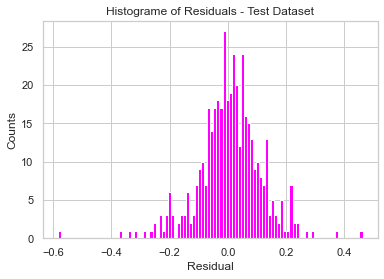

In [147]:
residuals_test = get_residuals(EN_model, X_test_scaled, y_test)
plt.hist(residuals_test, 100, facecolor = 'magenta');
plt.title('Histograme of Residuals - Test Dataset')
plt.ylabel('Counts')
plt.xlabel('Residual')

Linear Regression Model - Elastic Net


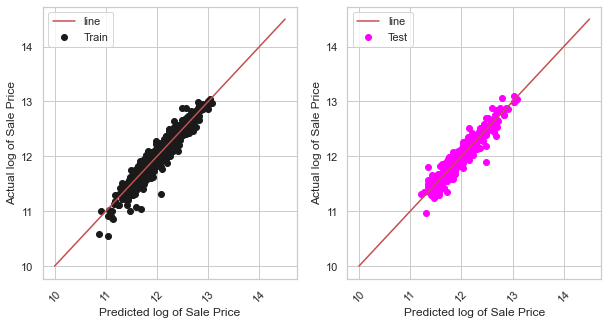

In [148]:
print('Linear Regression Model - Elastic Net');
plot_the_model(EN_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [149]:
which_model = 'Elastic Net'
append_myMetrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

In [150]:
pd.options.display.float_format = '{:,.4f}'.format
zipped = list(zip(model_descrp,
                 rmse_log_train, rmse_log_test, 
                 rmse_dollars_train, rmse_dollars_test,
                 r2_log_train, r2_log_test))

results = pd.DataFrame(zipped, columns=['model',
                                       'rmse log train',
                                       'rmse log test',
                                       'rmse train',
                                       'rmse test',
                                       'r2 train',
                                       'r2 test'])

#results.head(10)
results_sorted = results.sort_values('rmse log test', ascending = True)
results_sorted.head(10)

,model,rmse log train,rmse log test,rmse train,rmse test,r2 train,r2 test
3,Elastic Net,0.1039,0.1091,"17,870.9918","20,412.3988",0.9260,0.9132
1,Lasso,0.1083,0.1118,"18,592.6868","20,801.9575",0.9196,0.9089
2,Ridge,0.0963,0.1181,"16,707.6000","20,995.4083",0.9364,0.8985
0,Linear Regression,0.0965,"1,000.0000","16,707.2982",NaN,0.9362,"-1,000.0000"


In [151]:
EN_model.get_params

<bound method BaseEstimator.get_params of ElasticNet(alpha=0.004, l1_ratio=0.1)>

In [152]:
EN_model.intercept_

11.853042857167058

In [154]:
coefs = pd.DataFrame(
    EN_model.coef_,
    columns=["Coefficients"],
    index=preproc.columns,
)
coefs.head()

,Coefficients
LotFrontage,0.0086
LotArea,0.0246
OverallQual,0.0886
MasVnrArea,0.0027
BsmtFinSF1,0.0178


In [155]:
coefs.head(25)

,Coefficients
LotFrontage,0.0086
LotArea,0.0246
OverallQual,0.0886
MasVnrArea,0.0027
BsmtFinSF1,0.0178
BsmtUnfSF,-0.0147
TotalBsmtSF,0.0465
2ndFlrSF,0.0053
GrLivArea,0.1109
BedroomAbvGr,0.0000


### Non Linear Models
#### Label Encoding of Categorical Variables

### All Models
#### Standardization of numerical variables
#### Split train and validate datasets

<p><a name="EXP"></a></p>

## Exporting Cleaned Datasets